In [1]:
import pandas as pd
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 400)

In [2]:
from termcolor import colored, cprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

import joblib

In [3]:
def score_me(method, x_train_prepd, y_train):
    scores = cross_val_score(method, x_train_prepd, y_train, scoring="neg_mean_squared_error", cv=10)
    rmse_scores = np.sqrt(-scores)
    cprint(f"Mean score: {rmse_scores.mean():.2f}",'magenta')
    print(f"Standard deviation: {rmse_scores.std():.2f}")

### Take a look at data

In [4]:
sales = pd.read_csv('../data/sales_clean.csv')
print(sales.head(10))

                         lens_id   price  flen_min  flen_max  f_min     brand  \
0           nikon_50_1p8_g_sp_ed   150.0      50.0      -1.0    1.8     nikon   
1       canon_ts-e_135_4p0_macro   565.0     135.0      -1.0    4.0     canon   
2          fujifilm_xf_35_2_r_wr   275.0      35.0      -1.0    2.0  fujifilm   
3  sony_fe_200-600_5p6-6p3_g_oss  1775.0     200.0     600.0    5.6      sony   
4    fujifilm_xf_16-55_2p8_lm_wr   750.0      16.0      55.0    2.8  fujifilm   
5            sony_fe_85mm_1p4_gm  1245.0      85.0      -1.0    1.4      sony   
6     sony_zeiss_fe_70_200_4_oss   950.0      70.0     200.0    4.0      sony   
7    fujifilm_xf_16-55_2p8_lm_wr   700.0      16.0      55.0    2.8  fujifilm   
8                 sigma_50_1p4_a   500.0      50.0      -1.0    1.4     sigma   
9               fujifilm_xf_56mm   650.0      56.0      -1.0    1.2  fujifilm   

   original_price  announce_date  
0         276.950           2013  
1        2199.000           2017  
2  

In [5]:
sales.describe()

,price,flen_min,flen_max,f_min,original_price,announce_date
count,1957.000000,1957.000000,1957.000000,1957.000000,1957.000000,1957.000000
mean,657.950623,52.708738,78.610629,2.804446,1206.405378,2015.483393
std,483.446985,47.333853,129.280634,1.029993,765.386159,2.504261
min,0.000000,8.000000,-1.000000,1.200000,103.600000,2010.000000
25%,300.000000,24.000000,-1.000000,1.800000,599.000000,2013.000000
50%,575.000000,35.000000,18.000000,2.800000,996.950000,2015.000000
75%,875.000000,70.000000,105.000000,4.000000,1758.560000,2017.000000
max,2599.000000,300.000000,600.000000,5.600000,2999.000000,2020.000000


In [6]:
sales['lens_id'].nunique()

203

In [7]:
corr_matrix = sales.corr()
corr_matrix['price'].sort_values(ascending=False)

price             1.000000
original_price    0.666853
flen_max          0.402788
flen_min          0.367464
announce_date     0.355882
f_min             0.278100
Name: price, dtype: float64

### Prepare for training models

In [8]:
predict_ratio = False

if (predict_ratio):
    target = 'ret_value'
    sales['ret_value'] = sales['price']/sales['original_price']
    cprint(f'Mean resale/orig price: {sales.ret_value.mean()}','blue')
    cprint(f'Std resale/orig price: {sales.ret_value.std()}','blue')
else:
    target = 'price'
    cprint(f'Mean resale price: {sales.price.mean()}','blue')
    cprint(f'Std resale price: {sales.price.std()}','blue')

Mean resale price: 657.9506234031682
Std resale price: 483.44698525501985


In [9]:
train_set, test_set = train_test_split(sales, test_size=0.2, random_state=13)
cprint(f'Columns: {list(train_set)}')

Columns: ['lens_id', 'price', 'flen_min', 'flen_max', 'f_min', 'brand', 'original_price', 'announce_date']


In [10]:
x_train = train_set[['original_price', 'flen_max', 'flen_min', 'f_min','brand', 'announce_date']]
y_train = train_set[target]

In [11]:
list(x_train)

['original_price', 'flen_max', 'flen_min', 'f_min', 'brand', 'announce_date']

In [12]:
num_attr = list(x_train)
num_attr.remove('brand')
print('Numerical attributes to use:', num_attr)
cat_attr = ['brand']

full_pipeline = ColumnTransformer([
  ('num', StandardScaler(), num_attr), # some models don't care, but doesn't hurt
  ('cat', OneHotEncoder(), cat_attr),
  ])

Numerical attributes to use: ['original_price', 'flen_max', 'flen_min', 'f_min', 'announce_date']


In [13]:
x_train_prepd = full_pipeline.fit_transform(x_train)
print(f'Features shape: {x_train_prepd.shape}')

Features shape: (1565, 15)


### Explore model families with default params with cross-validation

In [14]:
score_me(LinearRegression(), x_train_prepd, y_train)

Mean score: 331.68
Standard deviation: 17.35


In [15]:
score_me(SVR(kernel='linear'), x_train_prepd, y_train)

Mean score: 337.29
Standard deviation: 19.18


In [16]:
score_me(SVR(kernel='rbf'), x_train_prepd, y_train)

Mean score: 450.37
Standard deviation: 23.75


In [17]:
score_me(DecisionTreeRegressor(random_state=15), x_train_prepd, y_train)

Mean score: 241.48
Standard deviation: 32.72


In [18]:
score_me(RandomForestRegressor(n_estimators=30, random_state=13), x_train_prepd, y_train)

Mean score: 238.87
Standard deviation: 29.30


In [19]:
score_me(GradientBoostingRegressor(max_depth=None, n_estimators=30, learning_rate=1.0), x_train_prepd, y_train)

Mean score: 242.09
Standard deviation: 32.78


Clear improvement going from Linear Regression and SVMs to Decision Tree, but then more complex models do not bring significant improvement. Proceed to optimize Decision Tree parameters.

### Check feature importance makes sense

In [20]:
tree_reg = DecisionTreeRegressor(random_state=15)
tree_reg.fit(x_train_prepd, y_train)

feats_importance = tree_reg.feature_importances_
all_attr = list(num_attr)
all_attr.extend(full_pipeline.named_transformers_['cat'].categories_[0])
sorted(zip(feats_importance, all_attr), reverse=True)

[(0.7118443196609222, 'original_price'),
 (0.0949898031646593, 'f_min'),
 (0.07907585009367396, 'sony'),
 (0.03787042363920575, 'flen_min'),
 (0.03562269235590614, 'fujifilm'),
 (0.01433482132959849, 'announce_date'),
 (0.013146171037988326, 'panasonic'),
 (0.005806445414329875, 'flen_max'),
 (0.005319904837684553, 'nikon'),
 (0.0010568385135337878, 'sigma'),
 (0.0004107889119391158, 'tamron'),
 (0.00031853691985101146, 'olympus'),
 (0.00020340412070756037, 'canon'),
 (0.0, 'samyang'),
 (0.0, 'leica')]

Looks like some brands are not highly correlated with the price, so try to create a category 'other' combining:
    ['sigma','panasonic','tamron','leica','canon','nikon','samyang']

In [21]:
sales = sales.replace(['sigma','tamron','olympus','canon','samyang','leica'],'other')

In [22]:
sales.head(10)

,lens_id,price,flen_min,flen_max,f_min,brand,original_price,announce_date
0,nikon_50_1p8_g_sp_ed,150.0,50.0,-1.0,1.8,nikon,276.950,2013
1,canon_ts-e_135_4p0_macro,565.0,135.0,-1.0,4.0,other,2199.000,2017
2,fujifilm_xf_35_2_r_wr,275.0,35.0,-1.0,2.0,fujifilm,409.475,2015
3,sony_fe_200-600_5p6-6p3_g_oss,1775.0,200.0,600.0,5.6,sony,1998.000,2019
4,fujifilm_xf_16-55_2p8_lm_wr,750.0,16.0,55.0,2.8,fujifilm,907.495,2015
5,sony_fe_85mm_1p4_gm,1245.0,85.0,-1.0,1.4,sony,1806.495,2016
6,sony_zeiss_fe_70_200_4_oss,950.0,70.0,200.0,4.0,sony,1323.000,2013
7,fujifilm_xf_16-55_2p8_lm_wr,700.0,16.0,55.0,2.8,fujifilm,907.495,2015
8,sigma_50_1p4_a,500.0,50.0,-1.0,1.4,other,805.440,2014
9,fujifilm_xf_56mm,650.0,56.0,-1.0,1.2,fujifilm,999.000,2014


In [23]:
num_attr

['original_price', 'flen_max', 'flen_min', 'f_min', 'announce_date']

In [24]:
train_set, test_set = train_test_split(sales, test_size=0.2, random_state=13)
x_train = train_set[['original_price', 'flen_max', 'flen_min', 'f_min','brand', 'announce_date']]
y_train = train_set[target]

x_train_prepd = full_pipeline.fit_transform(x_train)
print(f'Features shape: {x_train_prepd.shape}')

Features shape: (1565, 10)


In [25]:
score_me(DecisionTreeRegressor(random_state=15), x_train_prepd, y_train)

Mean score: 241.36
Standard deviation: 31.84


As expected, no explanatory power is lost while number of features is simplified.

### Optimize hyperparameters for Decision Tree model

In [26]:
distributions = {
        'max_depth': randint(low=1, high=50),
        'min_samples_split': randint(low=2, high=20),
        'min_samples_leaf': randint(low=1, high=20)
    }

rnd_search = RandomizedSearchCV(DecisionTreeRegressor(random_state=15), 
                                param_distributions=distributions,
                                n_iter=50, cv=5, scoring='neg_mean_squared_error', random_state=15)
rnd_search.fit(x_train_prepd, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features=None,
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   presort='deprecated',
                                                   random_state=15,
                                                   splitter='best'),
                   iid='dep

(array([ 2.,  0.,  0.,  0.,  0.,  4.,  5.,  1.,  9.,  4., 11.,  1.,  2.,
         1.,  4.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.]),
 array([242.18788561, 244.88555998, 247.58323434, 250.2809087 ,
        252.97858306, 255.67625742, 258.37393178, 261.07160614,
        263.7692805 , 266.46695486, 269.16462923, 271.86230359,
        274.55997795, 277.25765231, 279.95532667, 282.65300103,
        285.35067539, 288.04834975, 290.74602412, 293.44369848,
        296.14137284, 298.8390472 , 301.53672156, 304.23439592,
        306.93207028, 309.62974464, 312.327419  , 315.02509337,
        317.72276773, 320.42044209, 323.11811645, 325.81579081,
        328.51346517, 331.21113953, 333.90881389, 336.60648825,
        339.30416262, 342.00183698, 344.69951134, 347.3971857 ,
        350.09486006, 352.79253442, 355.49020878, 358.18788314,
        360.

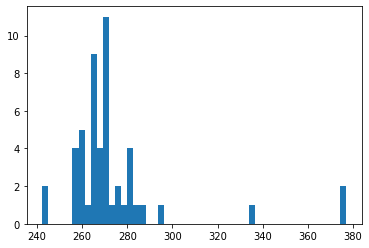

In [27]:
cvres = rnd_search.cv_results_
plt.hist(np.sqrt(-cvres["mean_test_score"]), bins=50)

Best performance consistent with default hyperparams, so leave at default.

### Check test RMSE

In [28]:
tree_reg = DecisionTreeRegressor(random_state=15)
tree_reg.fit(x_train_prepd, y_train)

x_test = test_set[['original_price', 'flen_max', 'flen_min', 'f_min','brand', 'announce_date']]
y_test = test_set[target]
x_test_prepd = full_pipeline.transform(x_test)
y_pred = tree_reg.predict(x_test_prepd)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
cprint(f"Test RMSE = {test_rmse:.2f}",'magenta')

Test RMSE = 248.93


Consistent with results on validation set, no signs of overfitting. 

### Retrain final model on all available data and save

In [29]:
x_all = sales[['original_price', 'flen_max', 'flen_min', 'f_min','brand', 'announce_date']]
y_all = sales[target]
x_all_prepd = full_pipeline.fit_transform(x_all)
print(f'Features shape: {x_all_prepd.shape}')

Features shape: (1957, 10)


In [30]:
tree_reg = DecisionTreeRegressor(random_state=15)
tree_reg.fit(x_all_prepd, y_all)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=15, splitter='best')

In [31]:
joblib.dump(tree_reg, "../data/resale_price_model.pkl")

['../data/resale_price_model.pkl']

In [32]:
joblib.dump(full_pipeline, "../data/prep_pipeline.pkl")

['../data/prep_pipeline.pkl']